# Fit meridional and temporal modes to zonally averaged NEMO and TAO data

In [1]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from numpy import pi
import scipy.io as sio
import matplotlib.colors as Colors
%matplotlib inline 
import warnings
import pandas as pd
from tqdm import tqdm
from utils.transform_utils import *
from utils.data_processing_utils import *
from utils.theoretical_utils import *

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 14, 'font.size': 14})
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['text.usetex'] = False

%load_ext autoreload
%autoreload 2

In [24]:
smooth_N = 21
SNR = 35
nmodes=6
cutoff = 20

In [25]:
# Load in full TAO data 
t_TAO_full, lat_TAO, lon_TAO, D_TAO_full, ds_TAO_full = load_TAO(nyears_start=0, nyears_end=37.6, NEMO_year=False, ilats = 'default', ilons = 'default')
lon_TAO_midpoints = np.array([158.5,172.5,185,197.5,212.5,227.5,242.5,257.5,272.5])

# Load in full NEMO data
t, lat_NEMO, lon_NEMO, D_NEMO_full, ds_NEMO_full = load_NEMO(daily_mean=True,lons='default',lats='default',lon_lims=[lon_TAO_midpoints[0],lon_TAO_midpoints[-1]])

# Load in year of TAO data 
t_TAO_year, lat_TAO, lon_TAO, D_TAO_year, ds_TAO_year = load_TAO(NEMO_year=True, ilats = 'default', ilons = 'default')

# Load in sampled NEMO data
t, lat_TAO, lon_TAO, D_NEMO_sampled, ds_NEMO_sampled = load_NEMO(daily_mean=True,lons=lon_TAO,lats=lat_TAO,lon_lims=[lon_TAO[0],lon_TAO[-1]])

# Add in gaps:
D_NEMO_sampled = np.where(np.isnan(D_TAO_year),np.nan,D_NEMO_sampled)


In [26]:
# Get the theoretical frequencies
freqbc1, freqbc2, lon_speeds = find_baroclinic_speeds(nmodes,lon_lims=[lon_TAO_midpoints[0],lon_TAO_midpoints[-1]],lat_lims=[-12,12],average = True)

In [27]:
# Load in meridional modes. We'll use the first baroclinic mode (cm = 2.8)
V_modes, P_modes_NEMO = calc_meridional_modes(lat_NEMO,N=nmodes,cm=2.8)
V_modes, P_modes_TAO = calc_meridional_modes(lat_TAO,N=nmodes,cm=2.8)


In [28]:
# Do high pass filters (two stage approach - first remove a running mean to remove endpoint issues)

D_NEMO_full_hf1 = D_NEMO_full - smooth(D_NEMO_full,smooth_N)
D_NEMO_sampled_hf1 = D_NEMO_sampled - smooth(D_NEMO_sampled,smooth_N)
D_TAO_year_hf1 = D_TAO_year - smooth(D_TAO_year,smooth_N)

D_NEMO_full_lf = least_squares_spectrum_t_multi(D_NEMO_full_hf1, t, min_period=2, max_period=370, SNR=SNR, reconstruct_min_period = cutoff)[2]
D_NEMO_full_hf = D_NEMO_full_hf1 - D_NEMO_full_lf
D_NEMO_full_hf -= np.nanmean(D_NEMO_full_hf,axis=0)

D_NEMO_sampled_lf = least_squares_spectrum_t_multi(D_NEMO_sampled_hf1, t, min_period=2, max_period=370, SNR=SNR, reconstruct_min_period = cutoff)[2]
D_NEMO_sampled_hf = D_NEMO_sampled_hf1 - D_NEMO_sampled_lf
D_NEMO_sampled_hf -= np.nanmean(D_NEMO_sampled_hf,axis=0)

D_TAO_year_lf = least_squares_spectrum_t_multi(D_TAO_year_hf1, t, min_period=2, max_period=370, SNR=SNR, reconstruct_min_period = cutoff)[2]
D_TAO_year_hf = D_TAO_year_hf1 - D_TAO_year_lf
D_TAO_year_hf -= np.nanmean(D_TAO_year_hf,axis=0)



In [29]:
# For the full TAO data, we need a windowed approach. Let's first create the windowed data, in yearly (370 day) intervals
window_width=370
Nsamples = D_TAO_full.shape[0]
window_starts = np.arange(0,Nsamples-window_width,window_width)
window_mid = window_starts+window_width/2
Nwindows = window_starts.shape[0]
D_TAO_windowed = np.zeros((window_width,D_TAO_full.shape[1],D_TAO_full.shape[2],Nwindows))
D_TAO_full_lf = np.zeros_like(D_TAO_windowed)
D_TAO_full_hf1 = np.zeros_like(D_TAO_windowed)
for iw in range(Nwindows):
    D_TAO_windowed[:,:,:,iw] = D_TAO_full[window_starts[iw]:window_starts[iw]+window_width]
    D_TAO_full_hf1[:,:,:,iw] = D_TAO_windowed[:,:,:,iw] - smooth(D_TAO_windowed[:,:,:,iw],smooth_N)
    D_TAO_full_lf[:,:,:,iw] = least_squares_spectrum_t_multi(D_TAO_full_hf1[:,:,:,iw], t, min_period=2, max_period=370, SNR=SNR, reconstruct_min_period = cutoff)[2]

D_TAO_full_hf = D_TAO_full_hf1 - D_TAO_full_lf
D_TAO_full_hf -= np.nanmean(D_TAO_full_hf,axis=0)    

In [30]:
# Now do zonal averages carefully

# For full NEMO, do a standard zonal average
D_NEMO_full_za = np.nanmean(D_NEMO_full_hf, axis=2)

# For sampled NEMO and TAO, need to check there are more than one data points in the zonal average
D_NEMO_sampled_za = np.zeros((D_NEMO_sampled_hf.shape[0],D_NEMO_sampled_hf.shape[1]))*np.nan
D_TAO_year_za  = np.zeros((D_TAO_year_hf.shape[0],D_TAO_year_hf.shape[1]))*np.nan

for it in range(0,370):
    for iy in range(0,D_TAO_year_hf.shape[1]):
        if (np.sum(~np.isnan(D_TAO_year_hf[it,iy,:])) > 1):
            D_TAO_year_za[it,iy] = np.nanmean(D_TAO_year_hf[it,iy,:])
            D_NEMO_sampled_za[it,iy] = np.nanmean(D_NEMO_sampled_hf[it,iy,:])

D_TAO_full_za  = np.zeros((D_TAO_full_hf.shape[0],D_TAO_full_hf.shape[1],D_TAO_full_hf.shape[3]))*np.nan
for iw in range(0,Nwindows):
    for it in range(0,370):
        for iy in range(0,D_TAO_full_hf.shape[1]):
            if (np.sum(~np.isnan(D_TAO_full_hf[it,iy,:,iw])) > 1):
                D_TAO_full_za[it,iy,iw] = np.nanmean(D_TAO_full_hf[it,iy,:,iw])


In [31]:
# Now do least squares fits:

omvec, power_NEMO_full, fit_NEMO_full = least_squares_spectrum_t_y(
    D_NEMO_full_za, t, lat_NEMO, min_period=2, max_period=370,y_modes=P_modes_NEMO,  SNR=SNR, max_period_cutoff = cutoff)

omvec, power_NEMO_sampled, fit_NEMO_sampled = least_squares_spectrum_t_y(
    D_NEMO_sampled_za, t, lat_TAO, min_period=2, max_period=370,y_modes=P_modes_TAO,  SNR=SNR, max_period_cutoff = cutoff)

omvec, power_TAO_year, fit_TAO_year = least_squares_spectrum_t_y(
    D_TAO_year_za, t, lat_TAO, min_period=2, max_period=370,y_modes=P_modes_TAO,  SNR=SNR, max_period_cutoff = cutoff)

omvec, power_TAO_full, fit_TAO_full = least_squares_spectrum_t_y(
    D_TAO_full_za, t, lat_TAO, min_period=2, max_period=370,y_modes=P_modes_TAO,  SNR=SNR, max_period_cutoff = cutoff)

power_TAO_full_av = np.nanmean(power_TAO_full,axis=2)



100%|███████████████████████████████████████████| 37/37 [01:06<00:00,  1.81s/it]


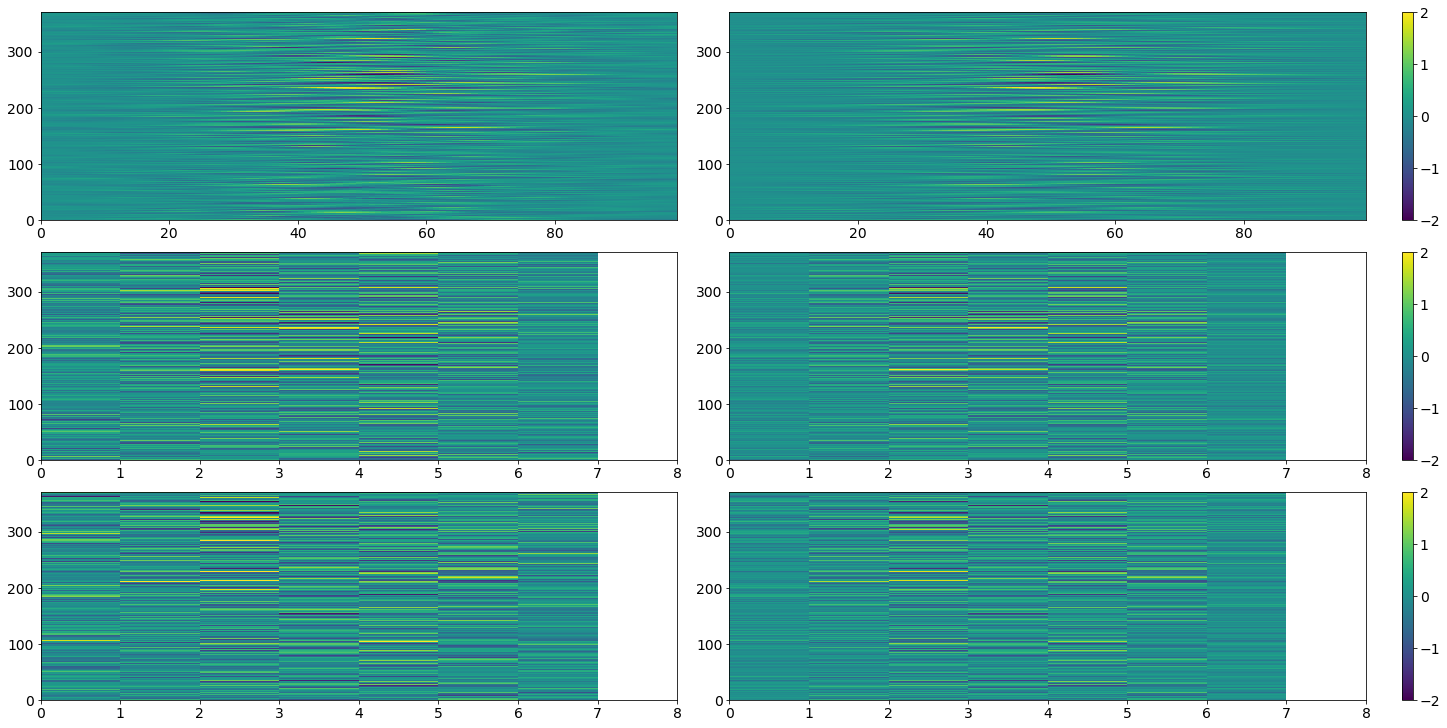

In [32]:
fig, ax = plt.subplots(3,2, constrained_layout=True)

p = ax[0,0].pcolormesh(D_NEMO_full_za, vmin = -2, vmax = 2)
ax[0,1].pcolormesh(fit_NEMO_full, vmin = -2, vmax = 2)
fig.colorbar(p,ax=ax[0,1])

p = ax[1,0].pcolormesh(D_NEMO_sampled_za, vmin = -2, vmax = 2)
ax[1,1].pcolormesh(fit_NEMO_sampled, vmin = -2, vmax = 2)
fig.colorbar(p,ax=ax[1,1])

p = ax[2,0].pcolormesh(D_TAO_year_za, vmin = -2, vmax = 2)
ax[2,1].pcolormesh(fit_TAO_year, vmin = -2, vmax = 2)
fig.colorbar(p,ax=ax[2,1])



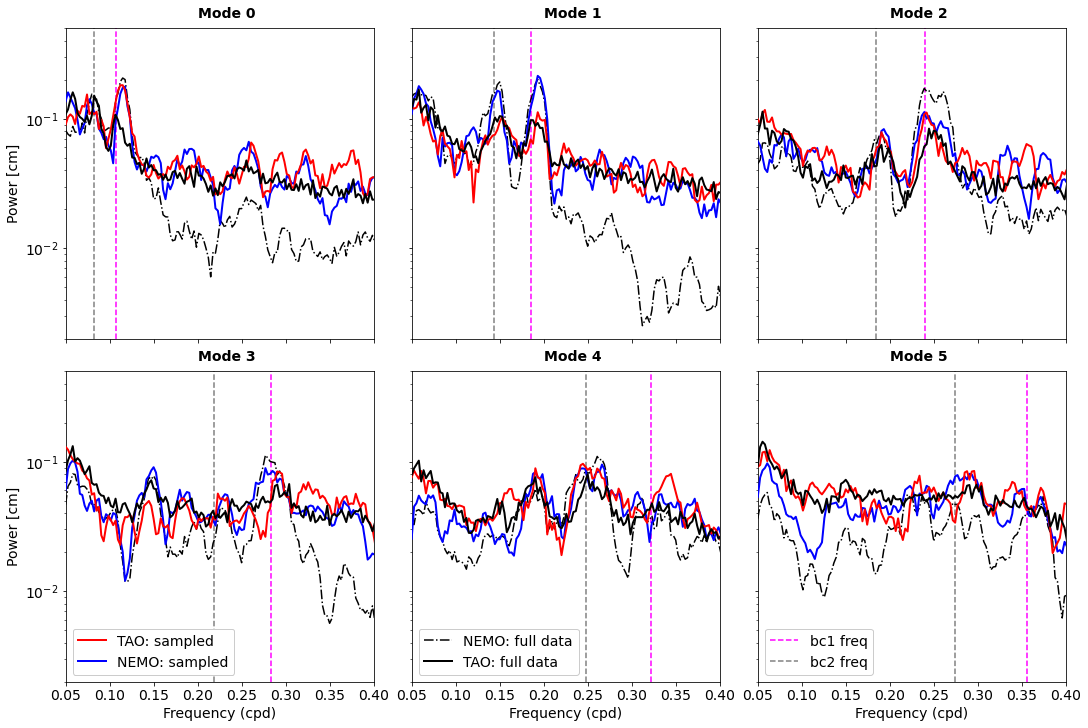

In [33]:

fig, ax = plt.subplots(2,3,figsize = (15,10), constrained_layout=True)

ymin = 2e-3
ymax = 0.5
nfilt=5

ax[0,0].plot(omvec,smooth(power_TAO_year[:,0],nfilt),'-', color='red',linewidth=2,zorder=6)
ax[0,1].plot(omvec,smooth(power_TAO_year[:,1],nfilt),'-', color='red',linewidth=2,zorder=6)
ax[0,2].plot(omvec,smooth(power_TAO_year[:,2],nfilt),'-', color='red',linewidth=2,zorder=6)
ax[1,0].plot(omvec,smooth(power_TAO_year[:,3],nfilt),'-', color='red',linewidth=2,label='TAO: sampled',zorder=6)
ax[1,1].plot(omvec,smooth(power_TAO_year[:,4],nfilt),'-', color='red',linewidth=2,zorder=6)
ax[1,2].plot(omvec,smooth(power_TAO_year[:,5],nfilt),'-', color='red',linewidth=2,zorder=6)


ax[0,0].plot(omvec,smooth(power_NEMO_sampled[:,0],nfilt),'-', color='blue',linewidth=2,zorder=5)
ax[0,1].plot(omvec,smooth(power_NEMO_sampled[:,1],nfilt),'-', color='blue',linewidth=2,zorder=5)
ax[0,2].plot(omvec,smooth(power_NEMO_sampled[:,2],nfilt),'-', color='blue',linewidth=2,zorder=5)
ax[1,0].plot(omvec,smooth(power_NEMO_sampled[:,3],nfilt),'-', color='blue',linewidth=2,zorder=5,label='NEMO: sampled')
ax[1,1].plot(omvec,smooth(power_NEMO_sampled[:,4],nfilt),'-', color='blue',linewidth=2,zorder=5)
ax[1,2].plot(omvec,smooth(power_NEMO_sampled[:,5],nfilt),'-', color='blue',linewidth=2,zorder=5)


ax[0,0].plot(omvec,smooth(power_NEMO_full[:,0],nfilt),'-.', color='black',linewidth=1.5,zorder=4)
ax[0,1].plot(omvec,smooth(power_NEMO_full[:,1],nfilt),'-.', color='black',linewidth=1.5,zorder=4)
ax[0,2].plot(omvec,smooth(power_NEMO_full[:,2],nfilt),'-.', color='black',linewidth=1.5,zorder=4)
ax[1,0].plot(omvec,smooth(power_NEMO_full[:,3],nfilt),'-.', color='black',linewidth=1.5,zorder=4)
ax[1,1].plot(omvec,smooth(power_NEMO_full[:,4],nfilt),'-.', color='black',linewidth=1.5,zorder=4,label='NEMO: full data')
ax[1,2].plot(omvec,smooth(power_NEMO_full[:,5],nfilt),'-.', color='black',linewidth=1.5,zorder=4)

ax[0,0].plot(omvec,power_TAO_full_av[:,0],'-', color='black',linewidth=2,zorder=7)
ax[0,1].plot(omvec,power_TAO_full_av[:,1],'-', color='black',linewidth=2,zorder=7)
ax[0,2].plot(omvec,power_TAO_full_av[:,2],'-', color='black',linewidth=2,zorder=7)
ax[1,0].plot(omvec,power_TAO_full_av[:,3],'-', color='black',linewidth=2,zorder=7)
ax[1,1].plot(omvec,power_TAO_full_av[:,4],'-', color='black',linewidth=2,label='TAO: full data',zorder=7)
ax[1,2].plot(omvec,power_TAO_full_av[:,5],'-', color='black',linewidth=2,zorder=7)



ax[0,0].plot([freqbc1[0],freqbc1[0]],[ymin,ymax],'--',color='magenta',zorder=1)
ax[0,0].plot([freqbc2[0],freqbc2[0]],[ymin,ymax],'--',color='gray',zorder=1)
ax[0,1].plot([freqbc1[1],freqbc1[1]],[ymin,ymax],'--',color='magenta',zorder=1)
ax[0,1].plot([freqbc2[1],freqbc2[1]],[ymin,ymax],'--',color='gray',zorder=1)
ax[0,2].plot([freqbc1[2],freqbc1[2]],[ymin,ymax],'--',color='magenta',zorder=1)
ax[0,2].plot([freqbc2[2],freqbc2[2]],[ymin,ymax],'--',color='gray',zorder=1)

ax[1,0].plot([freqbc1[3],freqbc1[3]],[ymin,ymax],'--',color='magenta',zorder=0)
ax[1,0].plot([freqbc2[3],freqbc2[3]],[ymin,ymax],'--',color='gray',zorder=0)
ax[1,1].plot([freqbc1[4],freqbc1[4]],[ymin,ymax],'--',color='magenta',zorder=0)
ax[1,1].plot([freqbc2[4],freqbc2[4]],[ymin,ymax],'--',color='gray',zorder=0)
ax[1,2].plot([freqbc1[5],freqbc1[5]],[ymin,ymax],'--',color='magenta',label='bc1 freq',zorder=0)
ax[1,2].plot([freqbc2[5],freqbc2[5]],[ymin,ymax],'--',color='gray',label='bc2 freq',zorder=0)



ax[0,0].text(0.2,0.6,'Mode 0',weight='bold',fontsize=14)
ax[0,1].text(0.2,0.6,'Mode 1',weight='bold',fontsize=14)
ax[0,2].text(0.2,0.6,'Mode 2',weight='bold',fontsize=14)
ax[1,0].text(0.2,0.6,'Mode 3',weight='bold',fontsize=14)
ax[1,1].text(0.2,0.6,'Mode 4',weight='bold',fontsize=14)
ax[1,2].text(0.2,0.6,'Mode 5',weight='bold',fontsize=14)


#ax[1,2].legend(ncol=2, mode="expand",facecolor='white',fontsize=13,framealpha=1)
ax[1,0].legend(facecolor='white',fontsize=14,framealpha=1,loc=3)
ax[1,1].legend(facecolor='white',fontsize=14,framealpha=1,loc=3)
ax[1,2].legend(facecolor='white',fontsize=14,framealpha=1,loc=3)

ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[0,2].set_yscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[1,2].set_yscale('log')

ax[0,0].set_xlim([0.05,0.4])
ax[0,1].set_xlim([0.05,0.4])
ax[0,2].set_xlim([0.05,0.4])
ax[1,0].set_xlim([0.05,0.4])
ax[1,1].set_xlim([0.05,0.4])
ax[1,2].set_xlim([0.05,0.4])

ax[0,1].axes.yaxis.set_ticklabels([])
ax[0,2].axes.yaxis.set_ticklabels([])
ax[1,1].axes.yaxis.set_ticklabels([])
ax[1,2].axes.yaxis.set_ticklabels([])

ax[0,0].axes.xaxis.set_ticklabels([])
ax[0,1].axes.xaxis.set_ticklabels([])
ax[0,2].axes.xaxis.set_ticklabels([])

ax[0,0].set_ylim([ymin,ymax])
ax[0,1].set_ylim([ymin,ymax])
ax[0,2].set_ylim([ymin,ymax])
ax[1,0].set_ylim([ymin,ymax])
ax[1,1].set_ylim([ymin,ymax])
ax[1,2].set_ylim([ymin,ymax])
ax[1,0].set_xlabel('Frequency (cpd)')
ax[1,1].set_xlabel('Frequency (cpd)')
ax[1,2].set_xlabel('Frequency (cpd)')
ax[0,0].set_ylabel('Power [cm]')
ax[1,0].set_ylabel('Power [cm]')
fig.savefig('new_figs/fig2_zonal_av_comparison_second_draft.png',transparent=False, bbox_inches="tight" )
